# Boundary Pass Central Node Model Results Slab

Assemble time series from a model results slab for Rich:

* NEMO-3.6 nowcast-green runs
* full water column
* hourly average results at Boundary Pass location of ONC mooring
* hourly average results at ONC central node
* 13-26 Jul-2016

*Note: The code in this notebook uses language features that are available only in Python 3.6 and later.*

In [1]:
import os
import pathlib

import arrow
import cmocean
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
%matplotlib inline

In [3]:
# ONC description of central node location:
# Depth: 297 m
# Latitude: 49.040066666
# Longitude: -123.425825
central_ji = (424, 266)
# ONC description of Boundary Pass mooring location:
# Depth: 230 m
# Latitude: 48.7665
# Longitude: -123.039556
boundary_ji = (343, 289)

## Region of Interest

In [4]:
bathy = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V16-07')

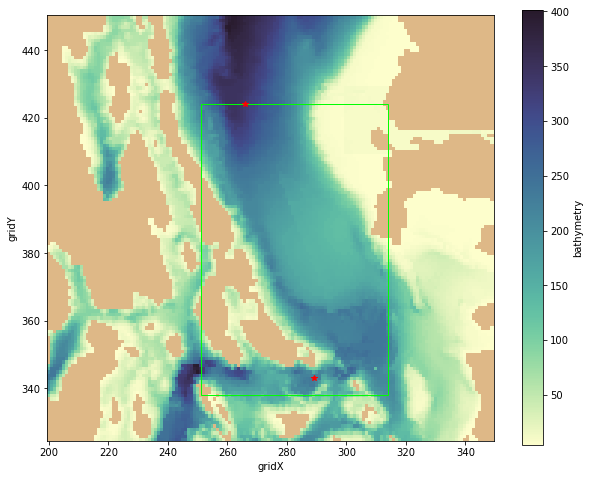

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect(5/4.4)

cmap = cmocean.cm.deep
cmap.set_bad('burlywood')
bathy.bathymetry.isel(gridY=slice(325, 451), gridX=slice(200, 350)).plot(ax=ax, cmap=cmap)

# Mark closest model points to Boundary Pass mooring and VENUS Central node with red stars
ax.plot(boundary_ji[1], boundary_ji[0], marker='*', color='red')
ax.plot(central_ji[1], central_ji[0], marker='*', color='red')

# Mark the x-y region of interest with at lime green rectangle
codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
offsets = {'north': 0, 'south': 5, 'east': 25, 'west': 15}
vertices = [
    (central_ji[1] - offsets['west'], boundary_ji[0] - offsets['south']),
    (central_ji[1] - offsets['west'], central_ji[0] + offsets['north']),
    (boundary_ji[1] + offsets['east'], central_ji[0] + offsets['north']),
    (boundary_ji[1] + offsets['east'], boundary_ji[0] - offsets['south']),
    (0, 0)]
vertices = np.array(vertices, float)
path = Path(vertices, codes)
pathpatch = PathPatch(path, facecolor='None', edgecolor='lime')
ax.add_patch(pathpatch)

## Dataset

* Index ranges in the `y` and `x` directions that define the region of interest above
* Results date range
* Time origin for the dataset we are building
* Results archive storage path
* List of dataset paths to process

In [6]:
y_slice = slice(boundary_ji[0] - offsets['south'], central_ji[0] + offsets['north'])
x_slice = slice(central_ji[1] - offsets['west'], boundary_ji[1] + offsets['east'])

start_date = arrow.get('2016-06-13')
end_date = arrow.get('2016-06-26')
time_origin = start_date.format('YYYY-MM-DD HH:mm:ss')

results_archive = pathlib.Path('/results/SalishSea/nowcast-green/')

datasets = []
for a in arrow.Arrow.range('day', start_date, end_date):
    ddmmmyy = a.format('DDMMMYY').lower()
    yyyymmdd = a.format('YYYYMMDD')
    results_dir = f'{ddmmmyy}'
    grid_T_1h = f'SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
    datasets.append(os.fspath(results_archive/results_dir/grid_T_1h))

The code below:

* opens the list of datasets generated above
* indexes into them to isolate the `(y_slice, x_slice)` region of interest
* creates a new dataset object containing, for each model grid point in the region of interest:

  * longitude and latitude
  * full depth salinity and temperature profiles
  
* stores the new dataset as a netCDF4 file

**Do not run the cell below in this notebook for more than 1 day for testing purposes!**

It requires a LOT of memory.

To produce the whole 2016-06-13 through 2016-06-26 dataset:

* save this notebook as a Python module
* use the `environment.yaml` file in this directory to create a conda environment to run the module in on `salish`
* activate the conda environment and execute the module from the command-line

In [ ]:
creation_time = arrow.now().format('YYYY-MM-DD HH:mm:ss ZZ')

with xr.open_mfdataset(datasets) as results:
    slab = results.isel(y=y_slice, x=x_slice)

    ds = xr.Dataset(
        data_vars={
            'nav_lon': slab.nav_lon,
            'nav_lat': slab.nav_lat,
            'vosaline': slab.vosaline,
            'votemper': slab.votemper,
        },
        attrs={
            'name': 'SalishSea_1h_20160613_20160626_T_grid',
            'title': 'SalishSeaCast Boundary Pass and ONC Central Node Temperature and Salinity Results',
            'conventions': 'CF-1.5',
            'source_code': 'https://bitbucket.org/salishsea/results/src/tip/BoundaryPassCentralNodeForRich/BoundaryPassCentralNodeResultsTimeSeries.py',
            'rendered_notebook': 'https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/results/raw/tip/BoundaryPassCentralNodeForRich/BoundaryPassCentralNodeResultsSlab.ipynb',
            'history': f'{creation_time}: Processed from results files in /results/SalishSea/nowcast-green/',
        },
    )

    ds.vosaline.attrs['standard_name'] = 'sea_water_reference_salinity'
    ds.vosaline.attrs['units'] = 'g kg-1'
    ds.time_centered.attrs['time_origin'] = f'hours since {time_origin}'
    ds.time_counter.attrs['time_origin'] = f'hours since {time_origin}'

    ds.to_netcdf(
        'SalishSea_1h_20160613_20160626_T_grid.nc',
        format='netCDF4', engine='netcdf4',
        encoding={
            'time_counter': {'units': 'hours since 2016-06-13 00:00:00'},
            'time_centered': {'units': 'hours since 2016-06-13 00:00:00'},
        },
        unlimited_dims='time_counter',
    )